# PCA with Multinomial Naive Bayes classifier on MNIST dataset

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import tensorflow.keras as keras
from sklearn.decomposition import PCA
from scipy.special import logsumexp
from sklearn.preprocessing import binarize, LabelBinarizer
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from PIL import Image

## Multinomial Naive Bayes Classifier

In [2]:
class NaiveBayesBase():    
    def predict(self, X):
        jll = self._joint_log_likelihood(X)
        return self.classes_[np.argmax(jll, axis=1)]

    def _log_proba(self, X):
        jll = self._joint_log_likelihood(X)
        log_prob_x = logsumexp(jll, axis=1)
        return jll - np.atleast_2d(log_prob_x).T

    def _proba(self, X):
        return np.exp(self._log_proba(X))
    
    def fit(self, X, y, sample_weight=None):
        _, n_f = X.shape
        lbin = LabelBinarizer()
        Y = lbin.fit_transform(y)
        self.classes_ = lbin.classes_
        if Y.shape[1] == 1:
            if len(self.classes_) == 2:
                Y = np.concatenate((1 - Y, Y), axis=1)
            else:
                Y = np.ones_like(Y)
        if sample_weight is not None:
            Y = Y.astype(np.float64, copy=False)
            sample_weight = np.atleast_2d(sample_weight)
            Y *= sample_weight.T
        n_c = Y.shape[1]
        self.c_count_ = np.zeros(n_c, dtype=np.float64)
        self.f_count_ = np.zeros((n_c, n_f), dtype=np.float64)
        self._count(X, Y)
        self._update_f_log_prob(self.alpha)
        self.c_log_prior_ = np.full(len(self.classes_), -np.log(len(self.classes_)))
        return self

    def score(self, X, y, sample_weight=None):
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

In [3]:
class MultinomialNB(NaiveBayesBase):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        
    def _count(self, X, y):
        self.f_count_ += safe_sparse_dot(y.T, X)
        self.c_count_ += y.sum(axis=0)

    def _update_f_log_prob(self, alpha):
        smoothed_fc = self.f_count_ + alpha
        smoothed_cc = smoothed_fc.sum(axis=1)
        self.f_log_prob_ = np.log(smoothed_fc) - np.log(smoothed_cc.reshape(-1, 1))

    def _joint_log_likelihood(self, X):
        return safe_sparse_dot(X, self.f_log_prob_.T) + self.c_log_prior_

## MNIST Dataset

The MNIST Dataset is a famous handwritten digit classification dataset that contains 60,000 images of handwritten 0 – 9 digits and 10,000 testing images. Each image has a label 0-9. The images are in black and white (so each pixel has 1 value), and have a 28 * 28 pixel dimension; thus, each image can be represented by a vector of size 28 * 28 = 784 where each entry is a real number that shows how dark that pixel is (the value of the pixel).

MNIST Dataset can be found here:
https://keras.io/api/datasets/mnist/

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = [np.reshape(x, 784) for x in X_train]
X_test = [np.reshape(x, 784) for x in X_test]

In [5]:
# Normalizing the input
X_train = np.asarray(X_train)
X_train = X_train.astype('float32')
X_train/=255
X_test = np.asarray(X_test)
X_test = X_test.astype('float32')
X_test/=255
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [6]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

([], <a list of 0 Text yticklabel objects>)

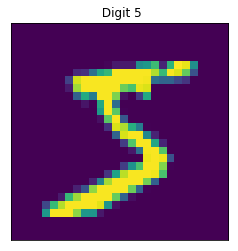

In [7]:
plt.imshow(np.reshape(X_train[0], (28,28)))
plt.title(" Digit " + str(y_train[0]) )
plt.xticks([])
plt.yticks([])

### Multinomial NB on MNIST Dataset

In [8]:
mnb = MultinomialNB().fit(X_train, y_train)
labelsm = mnb.predict(X_test)
print("Training score of Multinomial NB: %f" % mnb.score(X_train, y_train))
print("Test score of Multinomial NB: %f" % mnb.score(X_test, y_test))

Training score of Multinomial NB: 0.824683
Test score of Multinomial NB: 0.836100


In [9]:
score = accuracy_score(labelsm, y_test)
print(score)

0.8361


In [10]:
print("Multinomial NB Classifier report: \n\n", classification_report(y_test, labelsm))

Multinomial NB Classifier report: 

               precision    recall  f1-score   support

           0       0.92      0.93      0.93       980
           1       0.91      0.93      0.92      1135
           2       0.90      0.83      0.86      1032
           3       0.80      0.84      0.82      1010
           4       0.84      0.75      0.79       982
           5       0.86      0.66      0.75       892
           6       0.89      0.90      0.89       958
           7       0.93      0.84      0.88      1028
           8       0.66      0.80      0.72       974
           9       0.71      0.85      0.78      1009

   micro avg       0.84      0.84      0.84     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000



## PCA

n_components = 100

In [11]:
pca = PCA(n_components=100, svd_solver='auto').fit_transform(X)
pca = pca + abs(pca.min())
pca_train, pca_test, yy_train, yy_test = train_test_split(pca, y, random_state=42, test_size=0.142854)
mnb = MultinomialNB().fit(pca_train, yy_train)
labelsm = mnb.predict(pca_test)
print("Training score of Multinomial NB: %f" % mnb.score(pca_train, yy_train))
print("Test score of Multinomial NB: %f" % accuracy_score(labelsm, yy_test))

Training score of Multinomial NB: 0.806917
Test score of Multinomial NB: 0.809900


In [12]:
print("Multinomial NB Classifier report: \n\n", classification_report(yy_test, labelsm))

Multinomial NB Classifier report: 

               precision    recall  f1-score   support

           0       0.94      0.88      0.91       983
           1       0.78      0.96      0.86      1152
           2       0.85      0.78      0.82       967
           3       0.72      0.76      0.74      1034
           4       0.76      0.81      0.79       906
           5       0.76      0.68      0.71       937
           6       0.85      0.85      0.85       961
           7       0.89      0.84      0.87      1055
           8       0.82      0.71      0.76       969
           9       0.76      0.79      0.77      1036

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [13]:
n_comps = [10, 25, 50, 100, 225, 400]
for i in n_comps:
    pca = PCA(n_components=i, svd_solver='auto').fit_transform(X)
    pca = pca + abs(pca.min())
    pca_train, pca_test, yy_train, yy_test = train_test_split(pca, y, random_state=42, test_size=0.142854)
    mnb = MultinomialNB().fit(pca_train, yy_train)
    labelsm = mnb.predict(pca_test)
    print(f"PCA component size: {i}")
    print("Training score of Multinomial NB: %f" % mnb.score(pca_train, yy_train))
    print("Test score of Multinomial NB: %f" % accuracy_score(labelsm, yy_test))
    print('----------'*10)

PCA component size: 10
Training score of Multinomial NB: 0.719117
Test score of Multinomial NB: 0.724600
----------------------------------------------------------------------------------------------------
PCA component size: 25
Training score of Multinomial NB: 0.795567
Test score of Multinomial NB: 0.800200
----------------------------------------------------------------------------------------------------
PCA component size: 50
Training score of Multinomial NB: 0.805650
Test score of Multinomial NB: 0.810100
----------------------------------------------------------------------------------------------------
PCA component size: 100
Training score of Multinomial NB: 0.806417
Test score of Multinomial NB: 0.809800
----------------------------------------------------------------------------------------------------
PCA component size: 225
Training score of Multinomial NB: 0.806667
Test score of Multinomial NB: 0.810200
---------------------------------------------------------------------

In [14]:
pca = PCA(n_components=225, svd_solver='auto').fit_transform(X)
pca = pca + abs(pca.min())
pca_train, pca_test, yy_train, yy_test = train_test_split(pca, y, random_state=42, test_size=0.142854)
mnb = MultinomialNB().fit(pca_train, yy_train)
labelsm = mnb.predict(pca_test)
print("Training score of Multinomial NB: %f" % mnb.score(pca_train, yy_train))
print("Test score of Multinomial NB: %f" % accuracy_score(labelsm, yy_test))

Training score of Multinomial NB: 0.806800
Test score of Multinomial NB: 0.810200


In [15]:
print("Multinomial NB Classifier report: \n\n", classification_report(yy_test, labelsm))

Multinomial NB Classifier report: 

               precision    recall  f1-score   support

           0       0.94      0.88      0.91       983
           1       0.78      0.96      0.86      1152
           2       0.85      0.78      0.81       967
           3       0.72      0.77      0.74      1034
           4       0.77      0.81      0.79       906
           5       0.75      0.68      0.71       937
           6       0.86      0.85      0.86       961
           7       0.90      0.84      0.87      1055
           8       0.82      0.71      0.76       969
           9       0.76      0.79      0.77      1036

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



## New Challenge

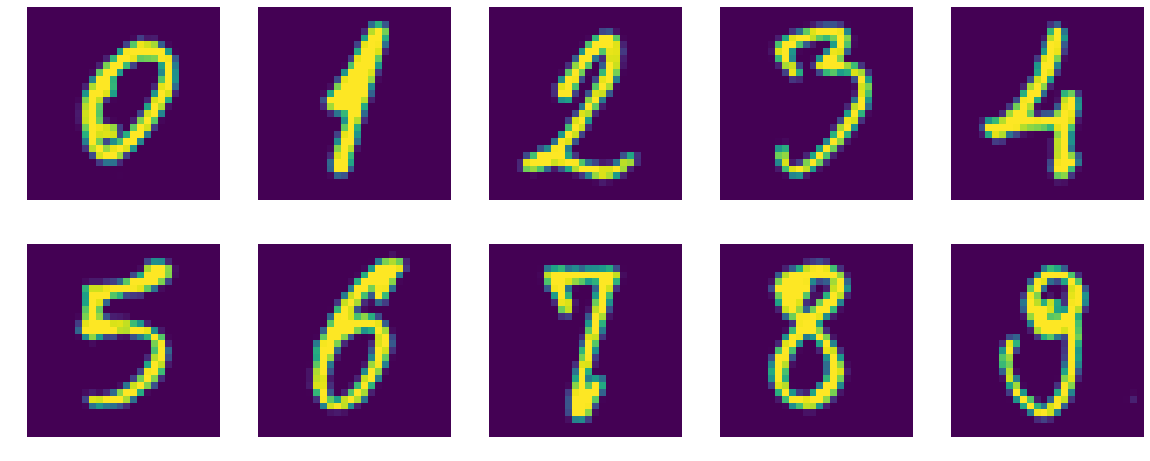

In [16]:
fig = plt.figure(figsize=(20,8))
images = []
_X = []
_y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in range(10):
    f = "./data/" + str(i) + ".png"
    img = Image.open(f).convert("L")
    images.append(img)
    a = np.ravel(np.asarray(img)/255)
    _X.append(a)
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(img)
    ax.axis("off")
plt.show()

In [17]:
print(len(_X[0]))

784


In [18]:
mnb = MultinomialNB().fit(X_train, y_train)
labelsm = mnb.predict(_X)
print("Training score of Multinomial NB: %f" % mnb.score(X_train, y_train))
#print("Test score of Multinomial NB: %f" % mnb.score(X_test, y_test))
print(labelsm)
print(_y)

Training score of Multinomial NB: 0.824683
[8 1 8 2 6 6 6 3 3 3]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
